# Brute-Force Hyperparameter Optimization

This notebook shows how to use the *BruteForce* optimizer module together with a **Midi2Vec** *Pipeline* to evaluate a large number of *Encoder* and *SequenceLearner* hyperparameter combinations against a given training set.

* **Encoder**: trains a *Doc2Vec* model against textual representations of MIDI files and uses this model to convert MIDI files into sequences of real-valued vectors.
* **SequenceLearner**: uses *Keras* to learn patterns in sequences of real-valued vectors and, once trained, can generate new sequences.
* **Pipeline**: combines various Midi2Vec components for encoding, sequence learning and evaluation into a single interface.
* **BruteForce**: Computes and evaluates all possible hyperparameter combinations with user-specified ranges.

## Imports

In [1]:
import sys
import logging
import pandas as pd
import seaborn as sns
%matplotlib inline

# Add Midi2Vec to Python working directory
sys.path.append('../')

from data_loading.data_loaders import MidiDataLoader
from midi_to_dataframe.note_mapper import NoteMapper
from pipeline.pipeline import Pipeline
from optimization.optimizers import BruteForce

Using TensorFlow backend.
/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Logging Configuration

In [2]:
logger = logging.getLogger()
logger.level = logging.INFO
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

## Brute-Force Hyperparameter Sweep Values

All individual hyperparameter values to evaluate should be explicitly defined below. The *BruteForce* module will then compute all of their possible permutations and train and evaluate the corresponding modules using each computed set of parameters.

In [20]:
# Documents used to train semantic encoder model
encoder_training_docs = "../../midi-embeddings/data/full_1_measure.txt"

param_sweep_values = {

    # Encoder (doc2vec) settings:
    'doc2vec_docs': [encoder_training_docs],
    'doc2vec_dm': [1],
    'doc2vec_dm_mean': [1],
    'doc2vec_epochs': [1,2],
    'doc2vec_hs': [0],
    'doc2vec_learning_rate_start': [0.025],
    'doc2vec_learning_rate_end': [0.2],
    'doc2vec_min_count': [5,10],
    'doc2vec_negative': [0],
    'doc2vec_vector_size': [20,24],
    'doc2vec_window': [1,2,3],

    # Sequence learning (Keras LSTM) settings:
    'nn_features': [['bpm', 'measure', 'beat']],
    'nn_batch_size': [25,50,75],
    'nn_dense_activation_function': ["linear"],
    'nn_dropout': [0],
    'nn_epochs': [20,30,40,50],
    'nn_hidden_neurons': [15,20,30],
    'nn_layers': [15,20,25],
    'nn_lstm_activation_function': ["selu"],
    'nn_lstm_n_prev': [12,16,20,24]
}

# 'Variables' are those hyperparameters with multiple values defined
variables = []
for key, value in param_sweep_values.items():
    if len(value) > 1:
        variables.append(key)

## Define Training Documents and DataLoader 

The training documents are MIDI sequences that the **Midi2Vec** model should learn to imitate and reproduce.

In [4]:
# Define note mapper for MIDI file loading
note_mapping_config_path = "../settings/map-to-group.json"
note_mapper = NoteMapper(note_mapping_config_path)

# Data loader used to encode MIDI-format training files
data_loader = MidiDataLoader(note_mapper)

# Define training documents for sequence learning
training_docs = ["../resources/breakbeats/084 Breakthru.mid",
                 "../resources/breakbeats/086 Clouds.mid",
                 "../resources/breakbeats/089 Get Out.mid",
                 "../resources/breakbeats/089 Wrong.mid",
                 "../resources/breakbeats/090 Deceive.mid",
                 "../resources/breakbeats/090 New York.mid",
                 "../resources/breakbeats/090 Radio.mid",
                 "../resources/breakbeats/093 Pretender.mid",
                 "../resources/breakbeats/093 Right Won.mid",
                 "../resources/breakbeats/094 Run.mid"]

## Define Callback Function

This function is called after every iteration of model training. It controls outputting intermediary results and can trigger early stopping of the evaluation pipeline. Since the space of all hyperparameter combinations to evaluate can be exponentially large, it may make sense to implement reasonable early stopping criteria, i.e. after a given number of single evaluations or a predetermined amount of time.

In [5]:
results_dfs = []
runs_completed = [0] # enclose Integer in List, so it is passed by reference
max_runs = 100

def callback(params, metrics):
    runs_completed[0] += 1
    merged = {**params, **metrics}
    merged['nn_features'] = ', '.join(merged['nn_features'])
    print("Completed " + str(runs_completed[0]) + " runs.")
    print(merged)
    results_dfs.append(pd.DataFrame(merged, index=[0]))
    if runs_completed[0] >= max_runs:
        print("Max. runcount reached.")
        # TODO, implement proper stopping procedure instead of sys.exit
        sys.exit(0)

## Build and Run the Pipeline

In [6]:
pipeline = Pipeline()
pipeline.set_data_loader(data_loader)
pipeline.set_training_docs(training_docs)
pipeline.set_k_fold_cross_eval(k=3)

brute_force_param_sweep = BruteForce(params=param_sweep_values)
brute_force_param_sweep.set_callback(callback)
pipeline.set_optimizer(brute_force_param_sweep)

pipeline.run()

Brute-force evaluation of 10368 hyperparameter combinations.
Loaded 100000 documents
Loaded 200000 documents
Loaded 300000 documents
Loaded 400000 documents
Loaded 500000 documents
Loaded 600000 documents
Loaded 700000 documents
Loaded 800000 documents
Loaded 900000 documents
Loaded 1000000 documents
Loaded 1100000 documents
Loaded 1200000 documents
Loaded 1300000 documents
Loaded 1400000 documents
Loaded 1500000 documents
Loaded 1600000 documents
Loaded 1700000 documents
collecting all words and their counts
PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
PROGRESS: at example #10000, processed 441984 words (4386969/s), 46 word types, 10001 tags
PROGRESS: at example #20000, processed 983041 words (4402307/s), 66 word types, 20001 tags
PROGRESS: at example #30000, processed 1348855 words (3856057/s), 78 word types, 30001 tags
PROGRESS: at example #40000, processed 1757176 words (4381390/s), 85 word types, 40001 tags
PROGRESS: at example #50000, processed 2131209 w

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x29235d0d0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


Completed [ runs.
{'nn_features': 'bpm, measure, beat', 'precision': 0.5300681352515041, 'nn_layers': 20, 'doc2vec_learning_rate_end': 0.2, 'recall': 0.47669039729667667, 'doc2vec_vector_size': 20, 'doc2vec_docs': '../../midi-embeddings/data/full_1_measure.txt', 'doc2vec_min_count': 5, 'nn_lstm_n_prev': 24, 'nn_hidden_neurons': 30, 'doc2vec_negative': 0, 'doc2vec_window': 1, 'nn_dense_activation_function': 'linear', 'nn_epochs': 50, 'doc2vec_hs': 0, 'doc2vec_dm': 1, 'doc2vec_learning_rate_start': 0.025, 'nn_batch_size': 50, 'doc2vec_epochs': 2, 'doc2vec_dm_mean': 1, 'f1': 0.49448297661495233, 'nn_lstm_activation_function': 'selu', 'nn_dropout': 0}
Completed [ runs.
{'nn_features': 'bpm, measure, beat', 'precision': 0.7444107624721791, 'nn_layers': 15, 'doc2vec_learning_rate_end': 0.2, 'recall': 0.68007272975461, 'doc2vec_vector_size': 20, 'doc2vec_docs': '../../midi-embeddings/data/full_1_measure.txt', 'doc2vec_min_count': 10, 'nn_lstm_n_prev': 16, 'nn_hidden_neurons': 20, 'doc2vec_neg

SystemExit: 0

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Collect and Aggregate Results of Runs 

In [7]:
results_df = pd.concat(results_dfs)

## Graph Averages of Single Variables

In [9]:
for variable in variables:
    print(results_df[[variable,'f1']].groupby([variable], as_index=False).median())

   doc2vec_epochs        f1
0               1  0.490001
1               2  0.493324
   doc2vec_min_count        f1
0                  5  0.493324
1                 10  0.493712
   nn_epochs        f1
0         20  0.404365
1         30  0.510031
2         40  0.516543
3         50  0.554019
   nn_batch_size        f1
0             25  0.558766
1             50  0.484127
2             75  0.425680
   doc2vec_vector_size        f1
0                   20  0.477516
1                   24  0.515517
   nn_lstm_n_prev        f1
0              12  0.453911
1              16  0.585361
2              20  0.469735
3              24  0.494483
   nn_hidden_neurons        f1
0                 15  0.476931
1                 20  0.485369
2                 30  0.517113
   nn_layers        f1
0         15  0.567263
1         20  0.494558
2         25  0.427444
   doc2vec_window        f1
0               1  0.499514
1               2  0.485369
2               3  0.501693


## Graph Variable Interactions

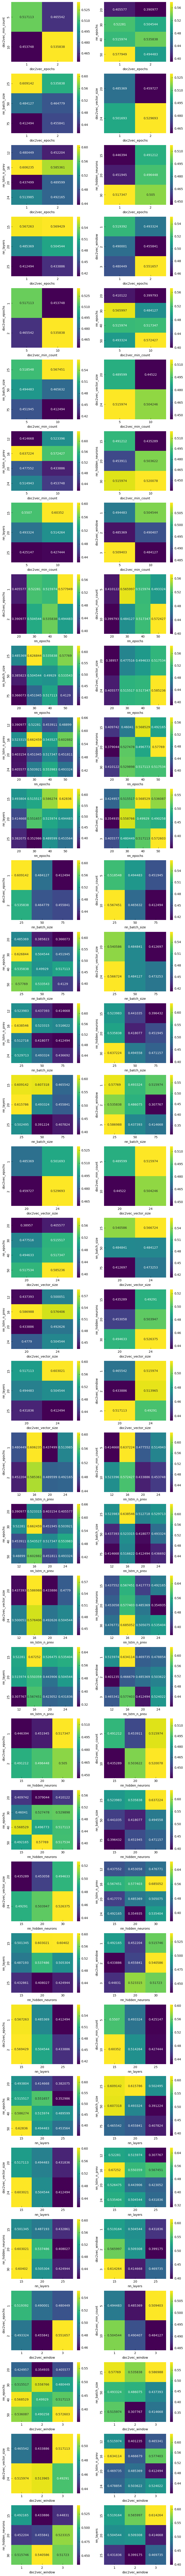

In [19]:
import matplotlib.pyplot as plt
import math

num_plots = len(variables) * len(variables) - len(variables)            
dim = math.ceil(num_plots / 2)

fig, axes = plt.subplots(dim, 2, sharex=False, sharey=False)
fig.set_size_inches(10, 150) # width, height

axis_index = 0
for heatmap_x in variables:
    for heatmap_y in variables:
        if heatmap_x != heatmap_y:
            grouped = results_df.groupby([heatmap_y, heatmap_x], as_index=False).median()
            pivoted = grouped.pivot(heatmap_y, heatmap_x, "f1")
            sns.heatmap(pivoted, annot=True, fmt="g", cmap='viridis', ax=axes.flat[axis_index])
            axis_index += 1